<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd





In [2]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.5200
True
{'login': 63134054, 'trade_mode': 2, 'leverage': 100, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 57.46, 'credit': 13.06, 'profit': 0.0, 'equity': 70.52, 'margin': 0.0, 'margin_free': 70.52, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'Bright Idowu ', 'server': 'OctaFX-Real', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 5370, 'maxbars': 100000000, 'codepage': 0, 'ping_last': 16144

In [3]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

70.52
AI is successfully functional


In [4]:
t_s = "BTCUSD"
market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_M5, 0, 10000000)
#display(market)
print(market.shape)

print(t_s)




(721508,)
BTCUSD


In [5]:
market

array([(1311242400, 1.369000e+01, 1.3780000e+01, 1.340000e+01, 1.3610000e+01,   69,    0, 0),
       (1311328800, 1.361000e+01, 1.3810000e+01, 1.345000e+01, 1.3700000e+01,   64,    0, 0),
       (1311415200, 1.370000e+01, 1.3760000e+01, 1.351000e+01, 1.3680000e+01,   49,    0, 0),
       ...,
       (1762522200, 9.987085e+04, 1.0008781e+05, 9.980455e+04, 9.9982470e+04, 2518, 2522, 0),
       (1762522500, 9.997827e+04, 1.0008497e+05, 9.988016e+04, 9.9987670e+04, 2364, 2520, 0),
       (1762522800, 9.999497e+04, 1.0014090e+05, 9.998097e+04, 1.0007871e+05,  224, 2533, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [6]:
data = []
for i in range(len(market)):
    data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
df = pd.DataFrame(data, columns=["open", "high","low", "close"])
df.to_csv("Generated"+t_s+" dbot.csv", index=False)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)


2.19.0


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scaler3d2d import preprocess_and_save_scalers,transform_data, inverse_transform_data,create_sequences



In [3]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import keras

In [4]:
t_symbol = ["AUDUSD"]

In [5]:


def engineer_features_5min_btc(df):
    """
    Input: df with columns ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    Output: df with 68 features
    """

    # GROUP 1: Core Price Features
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3

    # GROUP 7: Support/Resistance Features
    df['pivot_point'] = (df['high'].shift(1) + df['low'].shift(1) + df['close'].shift(1)) / 3

    return df

# Usage:
# df = pd.read_csv('btcusd_5min.csv')
# df = engineer_features_5min_btc(df)

In [6]:
n = 0
m_label = "Generated"+t_symbol[n]
pd.set_option('display.float_format', '{:.20f}'.format)
train_df = pd.read_csv(m_label+ " dbot.csv")/5
#train_df = engineer_features_5min_btc(train_df)[10:]

In [7]:
train_df

,open,high,low,close
0,0.14401999999999998137,0.14530000000000001248,0.14260000000000000453,0.14299999999999998823
1,0.14288000000000000700,0.14369999999999999440,0.14206000000000001959,0.14269999999999999352
2,0.14286000000000001475,0.14319999999999999396,0.14189999999999999836,0.14206000000000001959
3,0.14211999999999999633,0.14252000000000000779,0.14069999999999999174,0.14150000000000001465
4,0.14130000000000000893,0.14155999999999999139,0.14119999999999999218,0.14155999999999999139
...,...,...,...,...
334298,0.13022400000000000642,0.13034600000000001740,0.13018799999999999817,0.13027400000000000091
334299,0.13027400000000000091,0.13029599999999999516,0.13021800000000000042,0.13025599999999998291
334300,0.13025199999999997891,0.13029399999999999316,0.13021800000000000042,0.13025800000000001266
334301,0.13025800000000001266,0.13026199999999998891,0.13011800000000001143,0.13013999999999997792


In [8]:

#train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 360 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape


X, y = create_sequences(train_df.values, SEQ_LEN, 3, 0 )
train_df = None
n_samples = X.shape[0]
#print(X[-1])
print(y[-1])

GeneratedAUDUSD
[0.130252 0.130258 0.130134]


In [9]:
#X, y = preprocess_and_save_scalers(X, y)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)
X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=0, shuffle=False)
X = None
y = None

In [11]:

seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))

X = Bidirectional(LSTM(128, return_sequences=True))(i)
X = Bidirectional(LSTM(64, return_sequences=True))(X)
#X = Dropout(0.3)(X)

X = Bidirectional(LSTM(32))(X)
X = Dropout(0.3)(X)

X = Dense(32, activation="relu")(X)
X = Dropout(0.3)(X)

X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 360, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 360, 256)       │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 360, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,939 (1.31 MB)

 Trainable params: 343,939 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=1024,
  callbacks=[es, rlr, mc ],
  verbose=1

)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 0.0012 - mae: 0.0250 - mape: 15.8580 - msle: 8.8224e-04 - root_mean_squared_error: 0.0334
Epoch 1: val_loss improved from inf to 0.00001, saving model to GeneratedAUDUSDlstm_best.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 145s 642ms/step - loss: 0.0012 - mae: 0.0249 - mape: 15.8355 - msle: 8.8031e-04 - root_mean_squared_error: 0.0333 - val_loss: 1.4708e-05 - val_mae: 0.0037 - val_mape: 2.6261 - val_msle: 1.1350e-05 - val_root_mean_squared_error: 0.0038 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 1.2166e-04 - mae: 0.0081 - mape: 5.1339 - msle: 8.8579e-05 - root_mean_squared_error: 0.0110
Epoch 2: val_loss did not improve from 0.00001
219/219 ━━━━━━━━━━━━━━━━━━━━ 138s 632ms/step - loss: 1.2156e-04 - mae: 0.0081 - mape: 5.1316 - msle: 8.8506e-05 - root_mean_squared_error: 0.0110 - val_loss: 3.6596e-05 - val_mae: 0.0058 - val_mape: 4.1951 - val_msle: 2.8399e-05 - val_root_mean_squared_error: 0

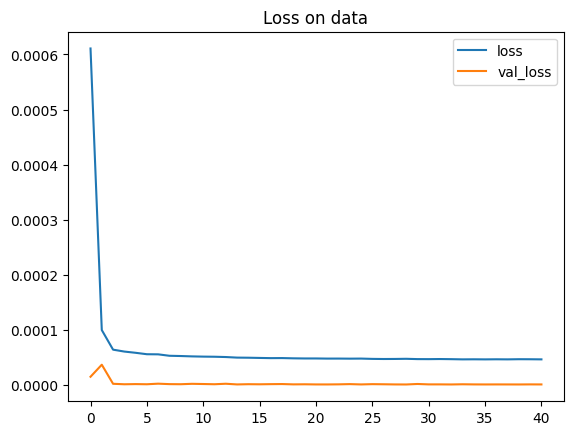

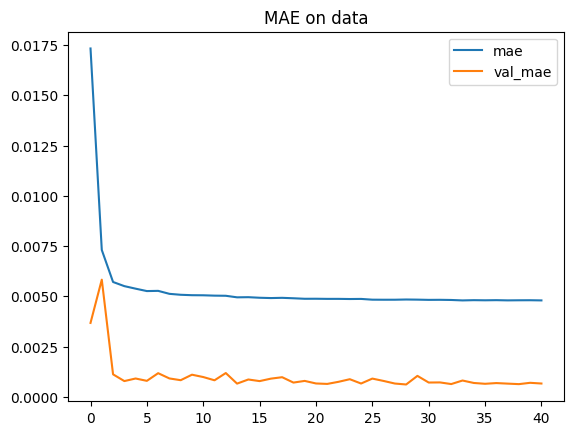

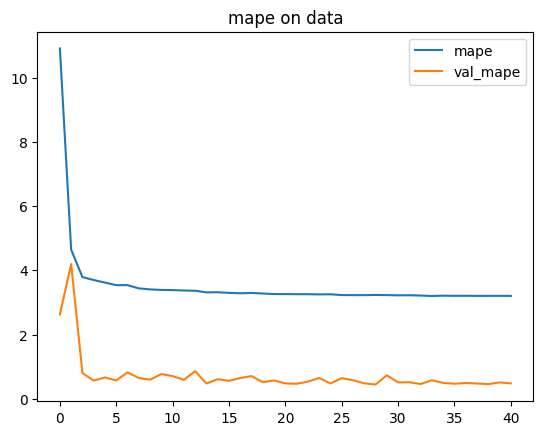

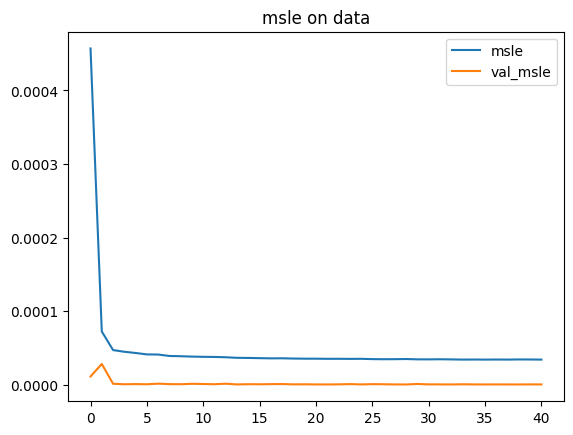

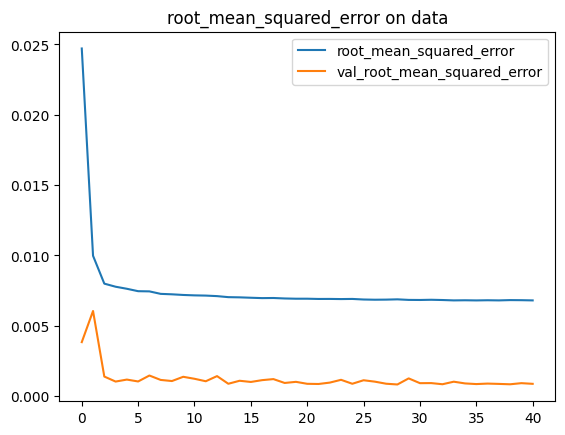

In [14]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

plt.title("mape on data")
plt.plot(r.history['mape'], label="mape")
plt.plot(r.history['val_mape'], label="val_mape")
plt.legend()
plt.show()

plt.title("msle on data")
plt.plot(r.history['msle'], label="msle")
plt.plot(r.history['val_msle'], label="val_msle")
plt.legend()
plt.show()

plt.title("root_mean_squared_error on data")
plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.legend()
plt.show()




In [15]:
m_label = "GeneratedAUDUSD"
best_model = load_model(m_label + 'lstm_best.keras')

In [16]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 360, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 360, 256)       │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 360, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031,819 (3.94 MB)

 Trainable params: 343,939 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 687,880 (2.62 MB)

In [17]:
y_pred = best_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [18]:
print(y_pred.shape)

(1103, 3)


In [19]:
#_,y_test = inverse_transform_data(scaled_y=y_test)
#_,y_pred = inverse_transform_data(scaled_y=y_pred)
print(y_test, " comparing to ", y_pred)

[[0.132042 0.13204  0.132084]
 [0.13204  0.132084 0.132054]
 [0.132084 0.132054 0.13217 ]
 ...
 [0.130224 0.130274 0.130252]
 [0.130274 0.130252 0.130258]
 [0.130252 0.130258 0.130134]]  comparing to  [[0.13196231 0.13193783 0.13200523]
 [0.13197167 0.13194716 0.13201459]
 [0.13197859 0.13195406 0.1320215 ]
 ...
 [0.1306517  0.13063051 0.13069421]
 [0.1306641  0.13064288 0.13070661]
 [0.13067688 0.13065562 0.13071941]]


In [20]:
# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")



Average Gap (Bias): -0.0002858

--- Example of Correction ---
Original Prediction: 0.1319623
Corrected Prediction: 0.1316766
Actual Value:        0.1320420


In [21]:
print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred_corrected))

R^2 value for  GeneratedAUDUSD
0.6495276628804005


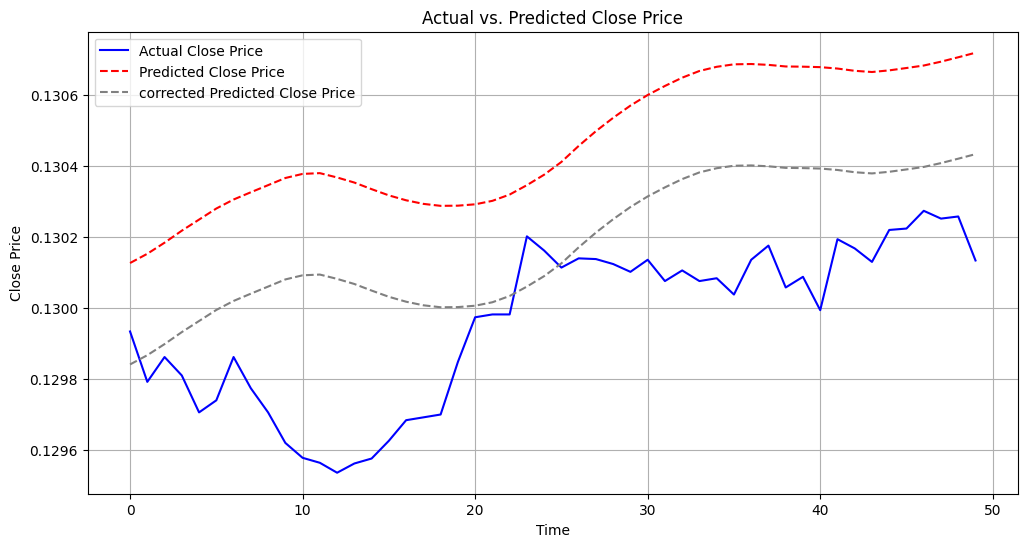

In [22]:




plt.figure(figsize=(12, 6))
plt.plot(y_test[-50:, 2], label='Actual Close Price', color='blue')
plt.plot(y_pred[-50:, 2], label='Predicted Close Price', color='red', linestyle='--')
plt.plot(y_pred_corrected[-50:, 2], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()
